### Instrucciones generales <a class="tocSkip"></a>

1. Forme un grupo de **máximo dos estudiantes**
1. Versione su trabajo usando un **repositorio <font color="red">privado</font> de github**. Agregue a su compañero y a su profesor (usuario github: phuijse) en la pestaña *Settings/Manage access*. No se aceptarán consultas si la tarea no está en github. No se evaluarán tareas que no estén en github.
1. Se evaluará el **resultado, la profundidad de su análisis y la calidad/orden de sus códigos** en base al último commit antes de la fecha y hora de entrega". Se bonificará a quienes muestren un método de trabajo incremental y ordenado según el histórico de *commits*
1. Sean honestos, ríganse por el [código de ética de la ACM](https://www.acm.org/about-acm/code-of-ethics-in-spanish)



# Tarea 3: Predicción de una serie de tiempo caótica

En esta tarea se pide entrenar y evaluar un predictor para el sistema no-lineal [Mackey-Glass](https://en.wikipedia.org/wiki/Mackey-Glass_equations)

Esta serie de tiempo se obtiene de la solución de la siguiente ecuación diferencial

$$
\frac{dy}{dt} = \beta \frac{ y(t-\tau)}{1 + y(t-\tau)^{n}} - \gamma y(t),
$$

donde el parámetro $\tau$ controla el comportamiento dinámico de la serie de tiempo 

En esta tarea nos limitaremos en estudiar el caso con $n=10$, $\gamma = 0.1$ y $\beta = 0.2$

El valor del parámetro $\tau$ modifica el comportamiento dinámico del sistema, en particular se tiene que

- $\tau = 17$ el sistema tiene un comportamiento debilmente caótico
- $\tau = 30$ el sistema tiene un comportamiento fuertemente caótico

La ecuación de diferencial anterior fue propuesta por Michael Mackey and Leon Glass en 1977 como modelo para procesos fisiológicos asociados a la [homeostasis](https://es.wikipedia.org/wiki/Homeostasis)

El código adjunto a esta tarea genera la serie de tiempo en función 

Se generan 1000 muestras de la serie de tiempo. Use los primeros 500 puntos para entrenar, los siguientes 250 puntos para calibrar los hiperparámetros y los últimos 250 para evaluar y comparar los filtros

<IPython.core.display.Javascript object>


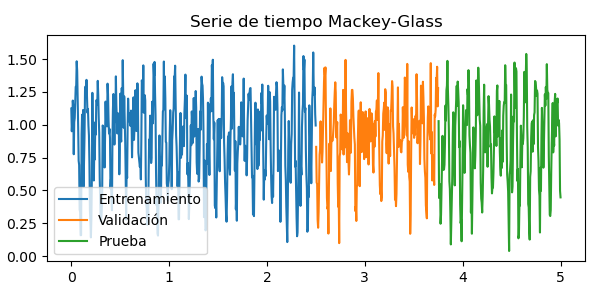

In [589]:
import numpy as np
%matplotlib notebook
import matplotlib.pylab as plt
from mackey import MackeyGlass

# Puede calcular el error medio cuadrático normalizado usando:
NMSE = lambda y, yhat : np.sum((y - yhat)**2)/np.var(y)

# Gráfico
(t_train, y_train), (t_valid, y_valid), (t_test, y_test, y_real) = MackeyGlass(tau=30.)
fig, ax = plt.subplots(figsize=(6, 3), tight_layout=True)
ax.plot(t_train, y_train, label='Entrenamiento')
ax.plot(t_valid, y_valid, label='Validación')
ax.plot(t_test, y_test, label='Prueba')
ax.set_title('Serie de tiempo Mackey-Glass');
ax.legend();


## (45%) Predicción con algoritmo LMS


### Describa en detalle el algoritmo LMS e implemente un predictor a un paso basado en el algoritmo LMS normalizado

Es un algoritmo adaptativo que utiliza gradiente descendente (estocastico) donde los pesos se actualizan basandose en el error de la salida actual (error instantaneo)

- Es una extension del filtro de Wiener que sirve para los casos no estacionarios

- No depende de la correlacion cruzada o autocorrelacion ni inversion de matrices
- Su solucion converge a la solucion del filtro de Wiener


Los pesos se inicializan en 0. 
Las correcciones sucesivas del vector de pesos convergen al valor minimo del error medio cuadratico (si la tasa de aprendizaje se encuentra en un determinado rango de valores).

LMS

- se calcula la salida y(n) a partir de la entrada x(n) (u(n)?) y el vector de pesos w
- se determina el error (cuadratico instantaneo) e(n) entre la salida deseada d(n) e y(n)
- se actualizan los pesos utilizando la regla de Widrow-Hoff
    - en la vesion normalizada (NLMS) se incorpora un temrino adicional a la regla iterativa que pondera el delta de los pesos por la varianza del vector u?.


In [590]:
class Filtro_NLMS:
    
    def __init__(self, L, mu, delta=1e-6, winit=None):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.mu = mu
        self.delta = delta
        
    def update(self, un, dn):
        # Asumiendo que un = [u[n], u[n-1], ..., u[n-L]]
        unorm = np.dot(un, un) + self.delta
        yn = np.dot(self.w, un)
        self.w += 2*self.mu*(dn - yn)*(un/unorm)
        return yn
    
    def predict(self, un):
        return np.dot(self.w, un)

### Considere el caso 𝜏=17. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros 𝜇 y 𝐿 que minimiza el NMSE en el conjunto de validación. Se recomienda realizar un barrido logarítmo para 𝜇. Para 𝐿 pruebe al menos los siguientes valores [5, 10, 20, 30]. Comente sobre lo que observa.

In [591]:
def train_NLMS(tau=17, L=None, mu=None):
    (t_train, y_train), (t_valid, y_valid), (t_test, y_test, y_real) = MackeyGlass(tau=tau)
    if L is not None:
        Ls = [L]
    else:
        #Ls = [5, 10, 20, 30]
        Ls = [3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]
    
    if mu is not None:
        mus = [mu]
    else:
        mus = np.logspace(-4, 0, num=20)
    
    best_nmse = np.inf
    for L in Ls:
        for mu in (mus):
            myfilter = Filtro_NLMS(L=L, mu=mu)
            #entrenar
            for k in range(L+1, len(y_train)):
                myfilter.update(y_train[k-L-1:k][::-1], y_train[k])

            u_pred = np.zeros(shape=(len(y_valid)))
            for k in range(L+1, len(y_valid)):
                u_pred[k] = myfilter.predict(y_valid[k-L-1:k][::-1])

            nmse = NMSE(y_valid, u_pred)
            if (nmse < best_nmse):
                best_filter = myfilter
                best_nmse = nmse
                best_mu = mu
                best_L = L
    print(f"Best NMSE : {best_nmse}\nL {best_L} , mu : {best_mu}")
    return best_filter, best_L, best_mu
    
def predict_NLMS(best_L, y_test):
    y_pred = np.zeros(shape=(len(y_test)))
    for k in range(best_L+1, len(y_test)):
        y_pred[k] = myfilter.predict(y_test[k-best_L-1:k][::-1])
    return y_pred


In [592]:
tau = 17
myfilter, best_L, best_mu = train_NLMS(tau=tau)

Best NMSE : 228.9522991558531
L 8 , mu : 0.08858667904100823


In [593]:
y_pred = predict_NLMS(best_L, y_test)

<IPython.core.display.Javascript object>


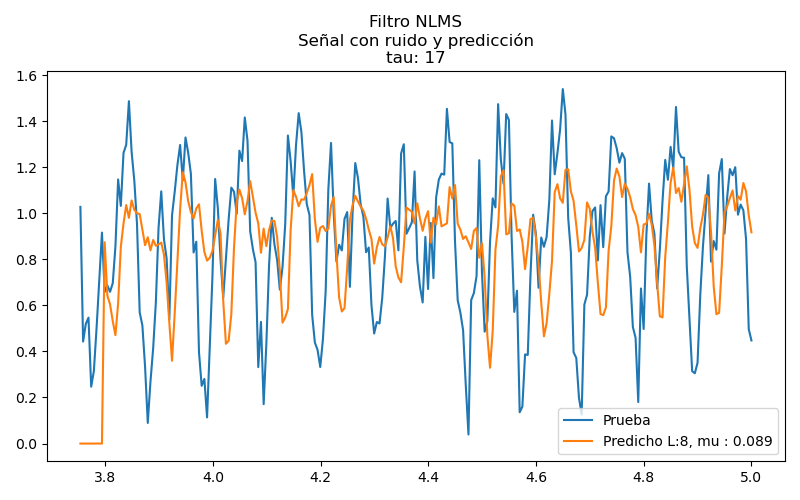

In [594]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_test, label='Prueba')
ax.plot(t_test, y_pred, label=f'Predicho L:{best_L}, mu : {best_mu:.3f}')
ax.legend()
ax.set_title(f'Filtro NLMS\nSeñal con ruido y predicción\ntau: {tau}');



<IPython.core.display.Javascript object>


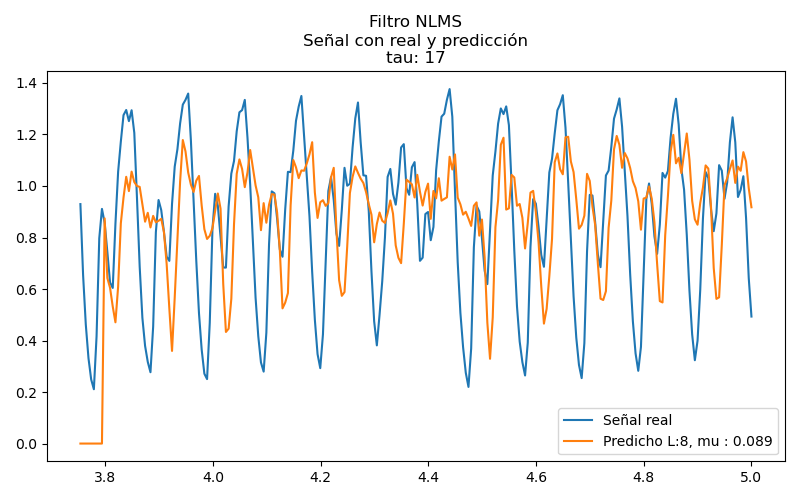

In [595]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_real, label='Señal real')
ax.plot(t_test, y_pred, label=f'Predicho L:{best_L}, mu : {best_mu:.3f}')
ax.legend()
ax.set_title(f'Filtro NLMS\nSeñal con real y predicción\ntau: {tau}');

### Repita el paso anterior para el caso $\tau = 30$ 

In [596]:
tau = 30
myfilter, best_L, best_mu = train_NLMS(tau=tau)

Best NMSE : 183.14739820095443
L 3 , mu : 0.08858667904100823


In [597]:
y_pred = predict_NLMS(best_L, y_test)

<IPython.core.display.Javascript object>


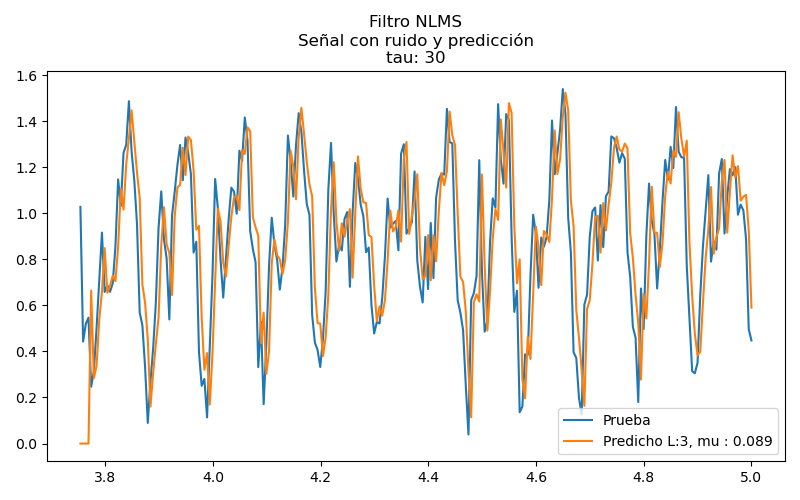

In [598]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_test, label='Prueba')
ax.plot(t_test, y_pred, label=f'Predicho L:{best_L}, mu : {best_mu:.3f}')
ax.legend()
ax.set_title(f'Filtro NLMS\nSeñal con ruido y predicción\ntau: {tau}');

<IPython.core.display.Javascript object>


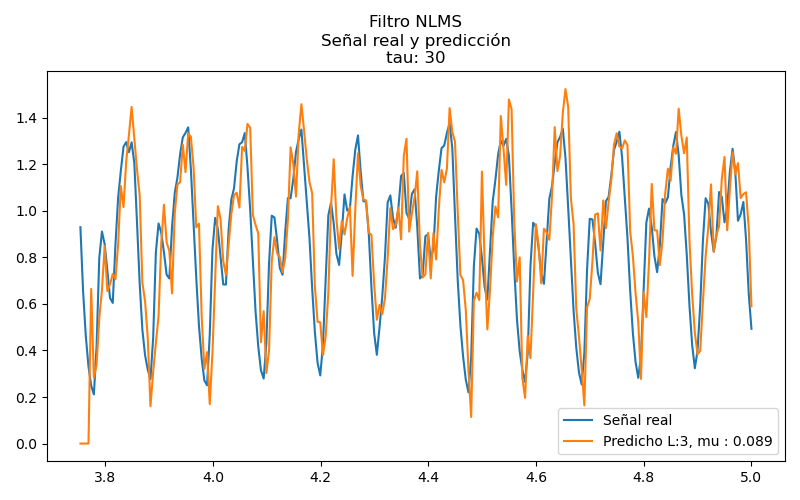

In [599]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_real, label='Señal real')
ax.plot(t_test, y_pred, label=f'Predicho L:{best_L}, mu : {best_mu:.3f}')
ax.legend()
ax.set_title(f'Filtro NLMS\nSeñal real y predicción\ntau: {tau}');

### (Falta) Muestre también los residuos. 

> Error cuadratico instantáneo: (señal original limpia - filtrada )^2

#### Discuta y analice sus resultados

* Mismo mu para 30 y 17

* Tau 17: 
    * Tiene menos ruido, no se sobreajusta tanto a la señal con ruido (no se parece tanto)
    * Respecto a la señal original, no es igual, pero mantiene la forma de la señal original y se diferencian bien sus puntos principales (es más pequeña? (de más baja frecuencia?) y sigue mantiendo ruido)
    
* Tau 30: 
    * es casi igual a la señal de prueba, se sobreajusta al ruido
    * tambien se parece mucho a la señal original, manteniendo la forma general mucho mejor que tau 17, pero los puntos principales (picos) no son tan definidos, contienen más ruido.

* ¿Por qué tau 17 es más chiquito que tau 30 pero más definido en sus puntos? y por qué tau 30 se ajusta mejor a la señal con ruido pero tambien a la señal original sin ruido pero no tan definido en los puntos?
    * Porque al ser más caotica es más dificil predecir bien sus puntos principales  pero es más facil definir su forma, en cambio al ser menos caotica es el caso contrario?

## (45%) Predicción con algoritmo RLS



### 1. Describa en detalle el algoritmo RLS e implemente un predictor a un paso basado en el algoritmo RLS. Resalte las diferencias con el algoritmo LMS


El algoritmo  RLS es un método online que minimiza el error histórico, es decir la suma de errores desde la muestra inicial hasta la actual filtros adaptativos para encontrar los coeficientes del filtro que permiten obtener el mínimo cuadrado de la señal de error en forma recursiva.

Tiene como caracteristica que toma la historia anterior del filtro, pero tambien la información actual y a medida que avanzo olvido del pasado.
* Hiperparametros:
    * Beta repercute en cuanta memoria tiene el filtro más cercano a 1, menos olvido, más cercano a 1, la mayoria de los factores serán 0. 

    * Lambda un regularizador que hace que ningun w sea demasiado grande.Mientras más pequeño el lambda, más pequeña la regularización
    

### Considere el caso $\tau=17$. Entrene su predictor en el conjunto de entrenamiento y encuentre la combinación de parámetros $\beta$ y $L$ que minimiza el NMSE en el conjunto de validación. Para $L$ pruebe al menos los siguientes valores 5, 10, 20, 30. Comente sobre lo que observa.

In [600]:
class Filtro_RLS:
    
    def __init__(self, L, beta=0.99, lamb=1e-2):
        self.L = L
        self.w = np.zeros(shape=(L+1, ))
        self.beta = beta
        self.lamb = lamb
        self.Phi_inv = lamb*np.eye(L+1)
        
    def update(self, un, dn):
        # Cálculo de la ganancia
        pi = np.dot(un.T, self.Phi_inv)
        kn = pi.T/(self.beta + np.inner(pi, un))
        # Actualizar el vector de pesos
        error = dn - np.dot(self.w, un)
        self.w += kn*error
        # Actualizar el inverso de Phi
        self.Phi_inv = (self.Phi_inv - np.outer(kn, pi))*self.beta**-1
        return np.dot(self.w, un)
    
    def predict(self, un):
        return np.dot(self.w, un)

In [601]:
def train_RLS(tau=17, L=None, b=None):
    (t_train, y_train), (t_valid, y_valid), (t_test, y_test, y_real) = MackeyGlass(tau=tau)
    if L is not None:
        Ls = [L]
    else:
        Ls = [5, 10, 20, 30]
        #Ls = [3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50]
    
    if b is not None:
        bs = [b]
    else:
        bs = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 0.99]
    
    best_nmse = np.inf
    for L in Ls:
        for b in (bs):
            myfilter = Filtro_RLS(L=L, beta=b)
            #entrenar
            for k in range(L+1, len(y_train)):
                myfilter.update(y_train[k-L-1:k][::-1], y_train[k])

            u_pred = np.zeros(shape=(len(y_valid)))
            for k in range(L+1, len(y_valid)):
                u_pred[k] = myfilter.update(y_valid[k-L-1:k][::-1], y_valid[k])

            nmse = NMSE(y_valid, u_pred)
            if (nmse < best_nmse):
                best_filter = myfilter
                best_nmse = nmse
                best_beta = b
                best_L = L
    print(f"Best NMSE : {best_nmse}\nL {best_L} , beta : {best_beta}")
    return best_filter, best_L, best_beta
 
    
def predict_RLS(best_L, y_test):
    y_pred = np.zeros(shape=(len(y_test)))
    for k in range(best_L+1, len(y_test)):
        y_pred[k] = myfilter.predict(y_test[k-best_L-1:k][::-1])

    return y_pred

In [602]:
tau = 17
myfilter, best_L, best_beta = train_RLS(tau=tau, b=0.99) ## Sacar b para usar best_beta segun barrido

Best NMSE : 196.42773764482976
L 5 , beta : 0.99


In [603]:
y_pred = predict_RLS(best_L, y_test)

<IPython.core.display.Javascript object>


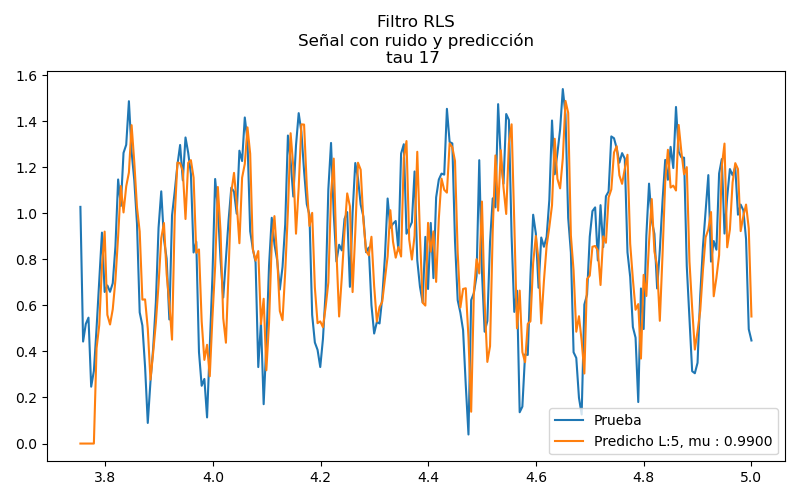

In [604]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_test, label='Prueba')
ax.plot(t_test, y_pred, label=f'Predicho L:{best_L}, mu : {best_beta:.4f}')

ax.legend()
ax.set_title(f'Filtro RLS\nSeñal con ruido y predicción\ntau {tau} ');

<IPython.core.display.Javascript object>


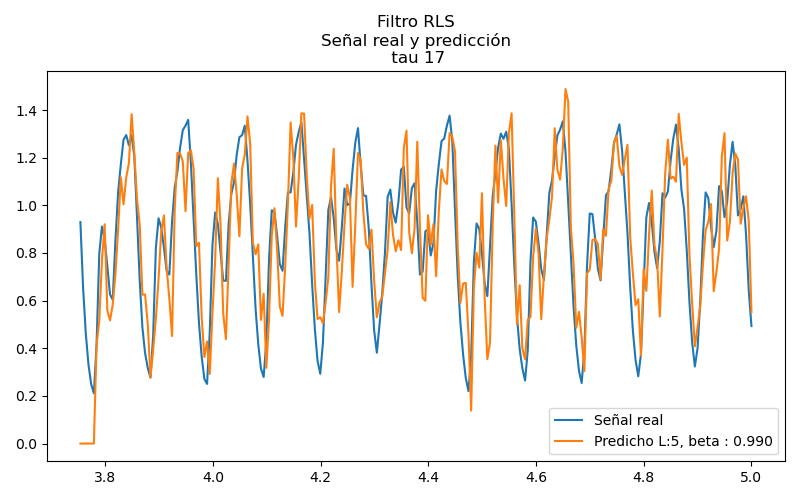

In [605]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_real, label='Señal real')
ax.plot(t_test, y_pred, label=f'Predicho L:{best_L}, beta : {best_beta:.3f}')

ax.legend()
ax.set_title(f'Filtro RLS\nSeñal real y predicción\n tau {tau}');

### Repita el paso anterior para el caso $\tau = 30$

In [606]:
tau = 30
myfilter, best_L, best_beta = train_RLS(tau=tau) ## Sacar b para usar best_beta segun barrido

/home/matias/miniconda3/envs/IA/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: overflow encountered in multiply
/home/matias/miniconda3/envs/IA/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in true_divide
  del sys.path[0]
/home/matias/miniconda3/envs/IA/lib/python3.7/site-packages/numpy/core/numeric.py:909: RuntimeWarning: invalid value encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)
/home/matias/miniconda3/envs/IA/lib/python3.7/site-packages/numpy/core/numeric.py:909: RuntimeWarning: overflow encountered in multiply
  return multiply(a.ravel()[:, newaxis], b.ravel()[newaxis, :], out)


Best NMSE : 19.916792983531778
L 5 , beta : 0.4


In [607]:
y_pred = predict_RLS(best_L, y_test)

<IPython.core.display.Javascript object>


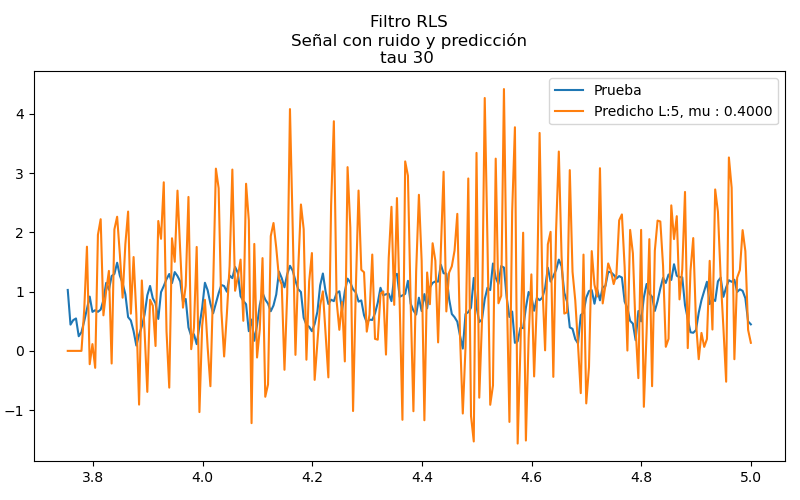

In [608]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_test, label='Prueba')
ax.plot(t_test, y_pred, label=f'Predicho L:{best_L}, mu : {best_beta:.4f}')

ax.legend()
ax.set_title(f'Filtro RLS\nSeñal con ruido y predicción\ntau {tau} ');

<IPython.core.display.Javascript object>


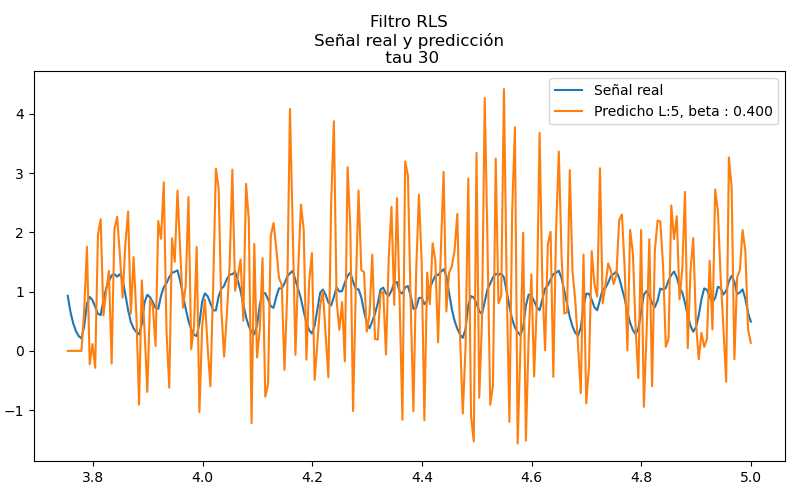

In [609]:
fig, ax = plt.subplots(figsize=(8, 5), tight_layout=True)
ax.plot(t_test, y_real, label='Señal real')
ax.plot(t_test, y_pred, label=f'Predicho L:{best_L}, beta : {best_beta:.3f}')

ax.legend()
ax.set_title(f'Filtro RLS\nSeñal real y predicción\n tau {tau}');

### (Falta) Muestre también los residuos. 

> Error cuadratico instantáneo: (señal original limpia - filtrada )^2

###  Compare los resultados obtenidos con cada serie de tiempo. Muestre la predicción en el conjunto de prueba versus su valor real. Muestre también los residuos. Discuta y analice sus resultados

## (10%) Comparación entre LMS y RLS

1. Compare el mejor predictor LMS y RLS en el conjunto de test en términos de la calidad de la predicción y la velocidad a la que sigue los cambios. Comente y discuta

> Si ambos estan bien calibrados el RLS deberia converger más rapido ver en la grafica de Error cuadratico instantáneo: (señal original limpia - filtrada )^2
